<a href="https://colab.research.google.com/github/Adhithya-Laxman/Image_classification/blob/main/image_classification_emnist.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install wandb

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 8.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 190.6/190.6 kB 13.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 248.6/248.6 kB 13.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.7/62.7 kB 6.6 MB/s eta 0:00:00


In [2]:
!pip install emnist
import joblib
from google.colab import files


In [3]:
# Task 1 -- Loading the datasets and the packages
import emnist
from keras.datasets import mnist
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import wandb
import random

In [4]:
import os
import json
import requests
import shutil

In [5]:
from emnist import extract_training_samples, extract_test_samples
import numpy as np
from sklearn.model_selection import train_test_split

def preprocess_emnist():
    # Load the EMNIST dataset
    (X_train, y_train) = extract_training_samples('letters')
    (X_test, y_test) = extract_test_samples('letters')

    # Flatten and normalize the input data
    X_train = X_train.reshape(-1, 28*28)  # Flatten each image to a 1D vector
    X_test = X_test.reshape(-1, 28*28)
    X_train = X_train.astype('float32') / 255.0  # Normalize pixel values to [0, 1]
    X_test = X_test.astype('float32') / 255.0

    # One-hot encode the labels
    num_classes = 62  # EMNIST has 62 classes (26 uppercase letters + 26 lowercase letters + 10 digits)
    y_train = np.eye(num_classes)[y_train]  # One-hot encode the training labels
    y_test = np.eye(num_classes)[y_test]    # One-hot encode the test labels

    # Split the data into training, validation, and test sets
    X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=6000, random_state=42)

    # Transpose the data to match the (features, batch_size) format expected by the function
    X_train = X_train.T
    X_val = X_val.T
    X_test = X_test.T

    y_train = y_train.T
    y_val = y_val.T
    y_test = y_test.T

    # Print the number of images in X and y for training, validation, and testing datasets
    print("Number of images in the training set =", X_train.shape[1])
    print("Number of images in the validation set =", X_val.shape[1])
    print("Number of images in the test set =", X_test.shape[1])
    print("Number of classes =", num_classes)
    print("Number of features per example =", X_train.shape[0])

    return X_train, y_train, X_val, y_val, X_test, y_test

# Preprocess the EMNIST dataset
X_train, Y_train, X_val, Y_val, X_test, Y_test = preprocess_emnist()
print(X_train.shape)
print(Y_train.shape)
print(X_test.shape)
print(Y_test.shape)


Number of images in the training set = 118800
Number of images in the validation set = 6000
Number of images in the test set = 20800
Number of classes = 62
Number of features per example = 784
(784, 118800)
(62, 118800)
(784, 20800)
(62, 20800)


In [6]:
#Install EMIST library, import datasets of letters, Matplotlib
from emnist import list_datasets
import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline

#Download dataset and it is 536 MB
list_datasets()

#Download images of letters from training samples or test samples
#from emnist import extract_test_samples
from emnist import extract_training_samples
images, labels = extract_training_samples('letters')
images.shape


(124800, 28, 28)

##Front End -- Anvil App


In [7]:
!pip install anvil-uplink

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 90.1/90.1 kB 697.1 kB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 51.4/51.4 kB 3.4 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for ws4py: filename=ws4py-0.5.1-py3-none-any.whl size=45227 sha256=95541e59492f399b4661b969f12d162e7e8a5fcf43ce3a4ee981ef7d962527b5
  Stored in directory: /root/.cache/pip/wheels/2e/7c/ad/d9c746276bf024d44296340869fcb169f1e5d80fb147351a57
Successfully built ws4py


In [8]:
import anvil.server

anvil.server.connect("server_LLD3GDKAAKN64WUQ6JUUVPC7-ZEXQT5UT7LKEFEGS")

Connecting to wss://anvil.works/uplink
Anvil websocket open
Connected to "Default Environment" as SERVER


In [9]:
def sigmoid(x):
    return 1. / (1.+np.exp(-x))

def sigmoid_derivative(x):
    return sigmoid(x) * (1-sigmoid(x))

def softmax_derivative(x):
    return softmax(x) * (1-softmax(x))

def tanh(x):
    return np.tanh(x)

def relu(x):
    return np.maximum(x, 0)

def softmax(x):
    expX = np.exp(x)
    return expX/np.sum(expX, axis = 0)
def derivative_tanh(x):
    return (1 - np.power(np.tanh(x), 2))

def derivative_relu(x):
    return np.array(x>0, dtype = np.float32)

In [10]:
# layer_dims = [X.shape[1],100,200,Y.shape[0]]
def initialize_parameters(layer_dims,init_mode):
    L = len(layer_dims)
    parameters = {}
    prev_updates = {}

    for l in range(1,L):
#         print(L)
        if init_mode == 'xavier':
              parameters[f"W{l}"]= np.random.randn(layer_dims[l],layer_dims[l-1])*np.sqrt(2/(layer_dims[l]+layer_dims[l-1]))
        else:
              parameters[f"W{l}"] = np.random.randn(layer_dims[l], layer_dims[l-1])*0.01  #the div is to prevent the vanishing gradient prob if the weights initialized at the beginning is too big
        parameters[f"b{l}"] = np.zeros((layer_dims[l], 1))
        prev_updates[f"W{l}"] = np.zeros((layer_dims[l], layer_dims[l-1]))
        prev_updates[f"b{l}"] = np.zeros((layer_dims[l], 1))

    return parameters,prev_updates

In [13]:
layer_dims = [X_train.shape[0], 100, 200, Y_train.shape[0]]
print(layer_dims)
params, prev_u = initialize_parameters(layer_dims,'xavier')

for l in range(1, len(layer_dims)):
    print("Shape of W" + str(l) + ":", params['W' + str(l)].shape)
    print("Shape of B" + str(l) + ":", params['b' + str(l)].shape, "\n")

[784, 100, 200, 62]
Shape of W1: (100, 784)
Shape of B1: (100, 1) 

Shape of W2: (200, 100)
Shape of B2: (200, 1) 

Shape of W3: (62, 200)
Shape of B3: (62, 1) 



In [14]:
def forward_prop(X, parameters, activation = 'relu'):
    forward_cache = {}
    L = len(parameters)//2
    forward_cache["A0"] = X
    for l in range(1, L):
        forward_cache[f"Z{l}"] = parameters[f"W{l}"].dot(forward_cache[f"A{l-1}"]) + parameters[f"b{l}"]
        if activation == 'relu':
            forward_cache[f"A{l}"] = relu(forward_cache[f"Z{l}"])
        else:
            forward_cache[f"A{l}"] = tanh(forward_cache[f"Z{l}"])


    forward_cache[f"Z{L}"] = parameters[f"W{L}"].dot(forward_cache[f"A{L-1}"]) + parameters[f"b{L}"]
    if forward_cache[f"Z{L}"].shape[0] == 1:
        forward_cache[f"A{L}"] = sigmoid(forward_cache[f"Z{L}"])
    else:
        forward_cache[f"A{L}"] = softmax(forward_cache[f"Z{L}"])

    return forward_cache[f"A{L}"], forward_cache




In [15]:
aL, forw_cache = forward_prop(X_train, params, 'relu')

for l in range(len(params)//2 + 1):
    print("Shape of A" + str(l) + " :", forw_cache['A' + str(l)].shape)

Shape of A0 : (784, 118800)
Shape of A1 : (100, 118800)
Shape of A2 : (200, 118800)
Shape of A3 : (62, 118800)


In [16]:
def compute_cost(AL, Y, parameters, lambd):
    m = Y.shape[1]
    L = len(parameters)//2
    if Y.shape[0] == 1:
        cost = -(1/m) * np.sum(Y*np.log(AL) + (1-Y)*np.log(1 - AL))
    else:
        cost = -(1/m) * np.sum(Y * np.log(AL))
        # reg_sum = 0
        # for l in range(1, L):
        #   reg_sum+=np.sum(np.square(parameters[f"W{l}"]))
        # L2_reg_cost = (lambd/(2*m)) * (reg_sum)
        # cost+=L2_reg_cost
    cost = np.squeeze(cost)

    return cost

In [17]:
def backward_propagation(AL , Y, parameters,forward_cache, activation, lambd = 0.7, batch_size = 512):
    grads = {}
    L = len(parameters)//2
    m = AL.shape[1]

    grads[f"dZ{L}"] = AL - Y
    grads[f"dW{L}"] = (1/m)*np.dot(grads[f"dZ{L}"], forward_cache[f"A{L-1}"].T) + (lambd*parameters[f"W{L}"])/m
    grads[f"db{L}"] = (1/m)*np.sum(grads[f"dZ{L}"], axis =1, keepdims  = True)

    for l in range(L-1, 0 , -1):
        if activation == 'relu':
            grads[f"dZ{l}"] = np.dot(parameters[f"W{l+1}"].T,grads[f"dZ{l+1}"]) * derivative_relu(forward_cache[f'A{l}'])
        else:
            grads[f"dZ{l}"] = np.dot(parameters[f"W{l+1}"].T,grads[f"dZ{l+1}"]) * derivative_tanh(forward_cache[f'A{l}'])

        grads[f"dW{l}"] = (1/batch_size)*np.dot(grads[f"dZ{l}"], forward_cache[f"A{l-1}"].T) + (lambd*parameters[f"W{l}"])/m
        grads[f"db{l}"] = (1/batch_size)*np.sum(grads[f"dZ{l}"], axis =1, keepdims  = True)

    return grads


In [18]:
grads = backward_propagation(forw_cache["A" + str(3)], Y_train, params, forw_cache, 'relu', 0.7)

for l in (range(1, len(grads)//3 + 1)):
    print("Shape of dZ" + str(l) + " :", grads['dZ' + str(l)].shape)
    print("Shape of dW" + str(l) + " :", grads['dW' + str(l)].shape)
    print("Shape of dB" + str(l) + " :", grads['db' + str(l)].shape, "\n")


Shape of dZ1 : (100, 118800)
Shape of dW1 : (100, 784)
Shape of dB1 : (100, 1) 

Shape of dZ2 : (200, 118800)
Shape of dW2 : (200, 100)
Shape of dB2 : (200, 1) 

Shape of dZ3 : (62, 118800)
Shape of dW3 : (62, 200)
Shape of dB3 : (62, 1) 



In [ ]:
index = random.randrange(0,X_train.shape[1])
plt.imshow(X_train[:, index].reshape(96,96,3), cmap = 'gray')
plt.show()
# # Define the neural network architecture

# # Input layer (784 features), 2 hidden layers (128 and 64 neurons), Output layer (10 classes)
layer_sizes = [784, 128,32,64,10]
# parameters, train_loss_history = train(X_train, y_train, layer_sizes, mode='xavier', activation='relu', loss_type='cross_entropy', num_epochs=5, learning_rate=0.1)

# # Make predictions on the test set
# y_pred = predict(X_test, parameters, layer_sizes,activation='relu')

# # Calculate accuracy on the test set
# accuracy = np.mean(np.argmax(y_pred, axis=0) == np.argmax(y_test, axis=1))
# print("Test Accuracy:", accuracy)



In [19]:
def update_parameters(parameters, grads, learning_rate):

    L = len(parameters) // 2
    for l in range(1, L):
        parameters[f"W{l}"] = parameters[f"W{l}"] - learning_rate*grads[f'dW{l}']
        parameters[f"b{l}"] = parameters[f"b{l}"] - learning_rate*grads[f'db{l}']
    return parameters

In [20]:
def grad_desc(X, Y, layer_dims, learning_rate, activation = 'relu', n_epoch = 100, lambd = 0.7):

    parameters, prev_updates = initialize_parameters(layer_dims, 'xavier')

    for i in range(n_epoch):

        AL , forward_cache  = forward_prop(X, parameters, activation)

        cost = compute_cost(AL, Y, parameters, lambd)

        grads = backward_propagation(AL , Y, parameters,forward_cache, activation)

        parameters = update_parameters(parameters, grads, learning_rate)

        if i % (n_epoch/10) == 0:
            print("\niter:{} \t cost: {} \t train_acc:{} \t test_acc:{}".format(i, np.round(cost, 2), predict(X_train, Y_train, parameters, activation), predict(X_test, Y_test, parameters, activation)))
        if i % 10 == 0:
            print("==", end = '')

    return parameters

In [21]:
def predict(X, y, parameters, activation):

    m = X.shape[1]
    y_pred, caches = forward_prop(X, parameters, activation)

    if y.shape[0] == 1:
        y_pred = np.array(y_pred > 0.5, dtype = 'float')
    else:
        y = np.argmax(y, 0)
        y_pred = np.argmax(y_pred, 0)
        # print(y, y_pred)
        # print(y.shape, y_pred.shape)

    return np.round(np.sum((y_pred == y)/m), 2)*100

In [ ]:
layer_dims = [X_train.shape[0], 20,10, Y_train.shape[0]]
lr = 0.005
n_epoch = 1000
activation = 'tanh'
init_mode = 'xavier'

parameters = grad_desc(X_train, Y_train, layer_dims, lr, activation = activation, n_epoch = n_epoch, lambd = 0.7)

In [22]:
def update_params_momentum(parameters, grads, learning_rate, prev_updates):
    L = len(parameters) // 2
    beta = 0.9
    for l in range(1, L+1):
        prev_updates[f"W{l}"] = beta*prev_updates[f"W{l}"] + (1-beta)*grads[f"dW{l}"]
        parameters[f"W{l}"] = parameters[f"W{l}"] - learning_rate*prev_updates[f"W{l}"]

        prev_updates[f"b{l}"] = beta*prev_updates[f"b{l}"] + (1-beta)*grads[f"db{l}"]
        parameters[f"b{l}"] = parameters[f"b{l}"] - learning_rate*prev_updates[f"b{l}"]
    return parameters, prev_updates
def update_parameters_sgd(parameters, grads, learning_rate):
    L = len(parameters) // 2
    for l in range(1, L):
        parameters[f"W{l}"] = parameters[f"W{l}"] - learning_rate*grads[f'dW{l}']
        parameters[f"b{l}"] = parameters[f"b{l}"] - learning_rate*grads[f'db{l}']
    return parameters

def update_params_rmsprop(parameters, grads, learning_rate, prev_rms):
    beta = 0.999
    L = len(parameters) // 2
    epsilon = 1e-6 #to prevent overshooting or 0 on the div
    for l in range(1, L+1):
        sdw = beta*prev_rms[f'W{l}'] + (1-beta)*np.multiply(grads[f"dW{l}"],grads[f"dW{l}"])
        sdb = beta*prev_rms[f'b{l}'] + (1-beta)*np.multiply(grads[f"db{l}"],grads[f"db{l}"])

        parameters[f"W{l}"] = parameters[f"W{l}"] - learning_rate*grads[f"dW{l}"]/(np.sqrt(sdw) + epsilon)
        parameters[f"b{l}"] = parameters[f"b{l}"] - learning_rate*grads[f"db{l}"]/(np.sqrt(sdb) + epsilon)

        prev_rms[f'W{l}'] = sdw
        prev_rms[f'b{l}'] = sdb

    return parameters, prev_rms

def update_params_adam(parameters, grads, learning_rate, v, m, t):
    L = len(parameters) // 2 # number of layers in the neural network
    beta1 = 0.9 #default
    beta2 = 0.999 #default
    epsilon = 1e-8 #for numerical stability

    for l in range(1, L+1):
        mdw = beta1*m["W"+str(l)] + (1-beta1)*grads["dW"+str(l)]
        vdw = beta2*v["W"+str(l)] + (1-beta2)*np.square(grads["dW"+str(l)])
        mw_hat = mdw/(1.0 - beta1**t)
        vw_hat = vdw/(1.0 - beta2**t)

        parameters["W"+str(l)] = parameters["W"+str(l)] - (learning_rate * mw_hat)/np.sqrt(vw_hat + epsilon)

        mdb = beta1*m["b"+str(l)] + (1-beta1)*grads["db"+str(l)]
        vdb = beta2*v["b"+str(l)] + (1-beta2)*np.square(grads["db"+str(l)])
        mb_hat = mdb/(1.0 - beta1**t)
        vb_hat = vdb/(1.0 - beta2**t)

        parameters["b"+str(l)] = parameters["b"+str(l)] - (learning_rate * mb_hat)/np.sqrt(vb_hat + epsilon)

        v["dW"+str(l)] = vdw
        m["dW"+str(l)] = mdw
        v["db"+str(l)] = vdb
        m["db"+str(l)] = mdb

    t = t + 1 # timestep
    return parameters, v, m, t


In [23]:
def grad_desc_opt(X, Y, layer_dims, learning_rate, init_mode = 'xavier',activation = 'relu', n_epoch = 100, lambd = 0.7, opt = 'adam',beta= 0.9):

    parameters, prev_updates = initialize_parameters(layer_dims, init_mode)
    v = prev_updates.copy()
    m = prev_updates.copy()
    # prev_updates['W0']  =0
    # prev_updates['b0'] = 0
    t=1
    for i in range(n_epoch):

        AL , forward_cache  = forward_prop(X, parameters, activation)

        cost = compute_cost(AL, Y, parameters, lambd)

        grads = backward_propagation(AL , Y, parameters,forward_cache, activation)

        parameters = update_parameters(parameters, grads, learning_rate)
        if(opt=='momentum'):
            parameters,prev_updates = update_params_momentum(parameters, grads, learning_rate,  prev_updates)
        elif (opt == 'rmsprop'):
            parameters,prev_updates = update_params_rmsprop(parameters, grads, learning_rate,  prev_updates)
        elif opt == 'adam':
            parameters, v, m , t= update_params_adam(parameters, grads, learning_rate, v, m, t)

        if i % (n_epoch/10) == 0:
            print("\niter:{} \t cost: {} \t train_acc:{} \t test_acc:{}".format(i, np.round(cost, 2), predict(X_train, Y_train, parameters, activation), predict(X_test, Y_test, parameters, activation)))
            # wandb.log("\niter:{} \t cost: {} \t train_acc:{} \t test_acc:{}".format(i, np.round(cost, 2), predict(X_train, Y_train, parameters, activation), predict(X_test, Y_test, parameters, activation)))
            wandb.log({"Iteration": i, "Cost": np.round(cost, 2), "Train_Accuracy": predict(X_train, Y_train, parameters, activation), "Test_Accuracy": predict(X_test, Y_test, parameters, activation)})


        if i % 10 == 0:
            print("==", end = '')

        # if i%800==0 and i!=0:
        #     break
    # wandb.log.compute_confusion_matrix
    # wandb.log({"conf_mat" : wandb.plot.confusion_matrix(preds=Y_prob, y_true=y_test,class_names=class_labels),"Test Accuracy": predict(X_test, Y_test, parameters, activation) })


    return parameters

In [24]:
def grad_desc_opt_bs(X, Y, layer_dims, learning_rate, init_mode = 'xavier',activation = 'relu', n_epoch = 100, lambd = 0.7, opt = 'adam', batch_size = 512):

    parameters, prev_updates = initialize_parameters(layer_dims, init_mode)
    v = prev_updates.copy()
    m = prev_updates.copy()
    # prev_updates['W0']  =0
    # prev_updates['b0'] = 0
    t=1
    step = 0
    for l in range(n_epoch):
        for i in range(0, X_train.shape[1], batch_size):
            batch_count = batch_size

            if i + batch_size > X_train.shape[1]: # the last mini-batch might contain fewer than "batch_size" examples
                batch_count = X_train.shape[1] - i + 1

            AL , forward_cache  = forward_prop(X, parameters, activation)

            cost = compute_cost(AL, Y, parameters, lambd)

            grads = backward_propagation(AL , Y, parameters,forward_cache, activation)

            # parameters = update_parameters(parameters, grads, learning_rate)
            if(opt=='momentum'):
                parameters,prev_updates = update_params_momentum(parameters, grads, learning_rate,  prev_updates)
            elif (opt == 'rmsprop'):
                parameters,prev_updates = update_params_rmsprop(parameters, grads, learning_rate,  prev_updates)
            elif opt == 'adam':
                parameters, v, m , t= update_params_adam(parameters, grads, learning_rate, v, m, t)


            step+=1
            if step%10==0:
                print("\niter:{} \t cost: {} \t train_acc:{} \t test_acc:{}".format(l, np.round(cost, 2), predict(X_train, Y_train, parameters, activation), predict(X_test, Y_test, parameters, activation)))

      # if l % (n_epoch/10) == 0:
      #     print("\niter:{} \t cost: {} \t train_acc:{} \t test_acc:{}".format(l, np.round(cost, 2), predict(X_train, Y_train, parameters, activation), predict(X_test, Y_test, parameters, activation)))
      # if l % 10 == 0:
      #     print("==", end = '')

    return parameters

In [ ]:
layer_dims = [X_train.shape[0], 20,10, Y_train.shape[0]]
lr = 0.0075
n_epoch = 1000
activation = 'relu'
init_mode = 'xavier'

parameters = grad_desc_opt(X_train, Y_train, layer_dims, lr, init_mode = init_mode,activation = activation, n_epoch = n_epoch, lambd = 0.7, opt= 'momentum')


In [ ]:
layer_dims = [X_train.shape[0], 128,128,128, Y_train.shape[0]]
lr = 0.001
n_epoch = 1000
activation = 'tanh'
init_mode = 'xavier'





parameters = grad_desc_opt(X_train, Y_train, layer_dims, lr,init_mode = 'xavier', activation = activation, n_epoch = n_epoch, lambd = 0.7, opt= 'rmsprop')


iter:0 	 cost: 4.13 	 train_acc:7.000000000000001 	 test_acc:7.000000000000001
iter:100 	 cost: 0.93 	 train_acc:73.0 	 test_acc:72.0
iter:200 	 cost: 0.74 	 train_acc:78.0 	 test_acc:77.0
iter:300 	 cost: 0.61 	 train_acc:82.0 	 test_acc:81.0
iter:400 	 cost: 1.0 	 train_acc:77.0 	 test_acc:75.0
iter:500 	 cost: 0.46 	 train_acc:86.0 	 test_acc:85.0
iter:600 	 cost: 0.4 	 train_acc:88.0 	 test_acc:86.0
iter:700 	 cost: 0.39 	 train_acc:88.0 	 test_acc:86.0
iter:800 	 cost: 0.44 	 train_acc:87.0 	 test_acc:85.0
iter:900 	 cost: 0.87 	 train_acc:75.0 	 test_acc:74.0

In [ ]:
layer_dims = [X_train.shape[0], 128,128,128, Y_train.shape[0]]
lr = 0.001
n_epoch = 1000
activation = 'tanh'
init_mode = 'xavier'





parameters = grad_desc_opt(X_train, Y_train, layer_dims, lr,init_mode = 'xavier', activation = activation, n_epoch = n_epoch, lambd = 0.7, opt= 'rmsprop')

In [ ]:
layer_dims = [X_train.shape[0], 128,128,128, Y_train.shape[0]]
lr = 0.001
n_epoch = 1
activation = 'relu'
init_mode = 'xavier'
parameters = grad_desc_opt(X_train, Y_train, layer_dims, lr,init_mode = init_mode, activation = activation, n_epoch = n_epoch, lambd = 0.7, opt= 'adam')





In [ ]:
print(predict(X_test, Y_test, parameters, activation))

NameError: ignored

In [ ]:
layer_dims = [X_train.shape[0], 128,128,128, Y_train.shape[0]]
lr = 0.0001
n_epoch = 100
activation = 'tanh'
init_mode = 'xavier'
batch_size  =5400
parameters = grad_desc_opt_bs(X_train, Y_train, layer_dims, lr,init_mode = init_mode, activation = activation, n_epoch = n_epoch, lambd = 0.7, opt= 'adam', batch_size = batch_size)



In [29]:
import numpy as np
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

def predict1(X, parameters, activation='tanh'):

    # Forward propagation
    A, _ = forward_prop(X, parameters, activation)

    # Convert probabilities to class labels
    predictions = np.argmax(A, axis=0)

    return predictions

def plot_confusion_matrix(conf_matrix, classes, title='Confusion Matrix', figsize=(26, 20), save_path=None):
      plt.figure(figsize=figsize)
      sns.set(font_scale=1.2)
      sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', cbar=False,
                  xticklabels=classes, yticklabels=classes)
      plt.xlabel('Predicted')
      plt.ylabel('True')
      plt.title(title)

      if save_path:
          plt.savefig(save_path, dpi=300, bbox_inches='tight')
      else:
          plt.show()

def compute_confusion_matrix(parameters, X_val, Y_val, classes, activation='tanh'):
    predictions = predict1(X_val, parameters, activation)
    conf_matrix = confusion_matrix(Y_val.argmax(axis=0), predictions)

    return conf_matrix

# Call the function to compute and plot the confusion matrix
# conf_matrix = compute_confusion_matrix(parameters, X_val, Y_val, class_labels)


In [ ]:
#training function to sweep with wandb
# parameters = grad_desc_opt(X_train, Y_train, layer_dims, lr,init_mode = init_mode, activation = activation, n_epoch = n_epoch, lambd = 0.0, opt= 'adam')

def train():

    hyperparameter_defaults=dict(
        n_epoch = 1000,
        n_hiddenlayer = 3,
        lambd = 0.7,
        lr = 0.001,
        opt = "adam",
        init_mode = "xavier",
        activation = 'tanh'
    )

    wandb.init(config=hyperparameter_defaults)

    config=wandb.config
    config.layer_dims = [X_train.shape[0]] + [128] * config.n_hiddenlayer + [Y_train.shape[0]]
    print(config.layer_dims)

    print("Parameters: ",config.layer_dims,config.lr,config.init_mode,config.activation,config.n_epoch,config.lambd,config.opt)
    parameters=grad_desc_opt(X_train, Y_train,config.layer_dims,config.lr,config.init_mode,config.activation,config.n_epoch,config.lambd,config.opt)

    joblib.dump(parameters, 'trained_parameters.joblib')


    class_labels = ['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J',
                  'K', 'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T',
                  'U', 'V', 'W', 'X', 'Y', 'Z']

    # Example usage:
    # print(class_labels)

    conf_matrix = compute_confusion_matrix(parameters, X_val, Y_val, class_labels)
    conf_matrix_path = "confusion_matrix.png"
    plot_confusion_matrix(conf_matrix, class_labels, title='Confusion Matrix', save_path=conf_matrix_path)

  # Upload the confusion matrix image to WandB
    wandb.log({"Confusion_Matrix": wandb.Image(conf_matrix_path)})
    # sweeper(sweep_config,proj_name)


In [25]:
from google.colab import files

# Upload the trained parameters file
uploaded = files.upload()

Saving rms_trained.joblib to rms_trained.joblib


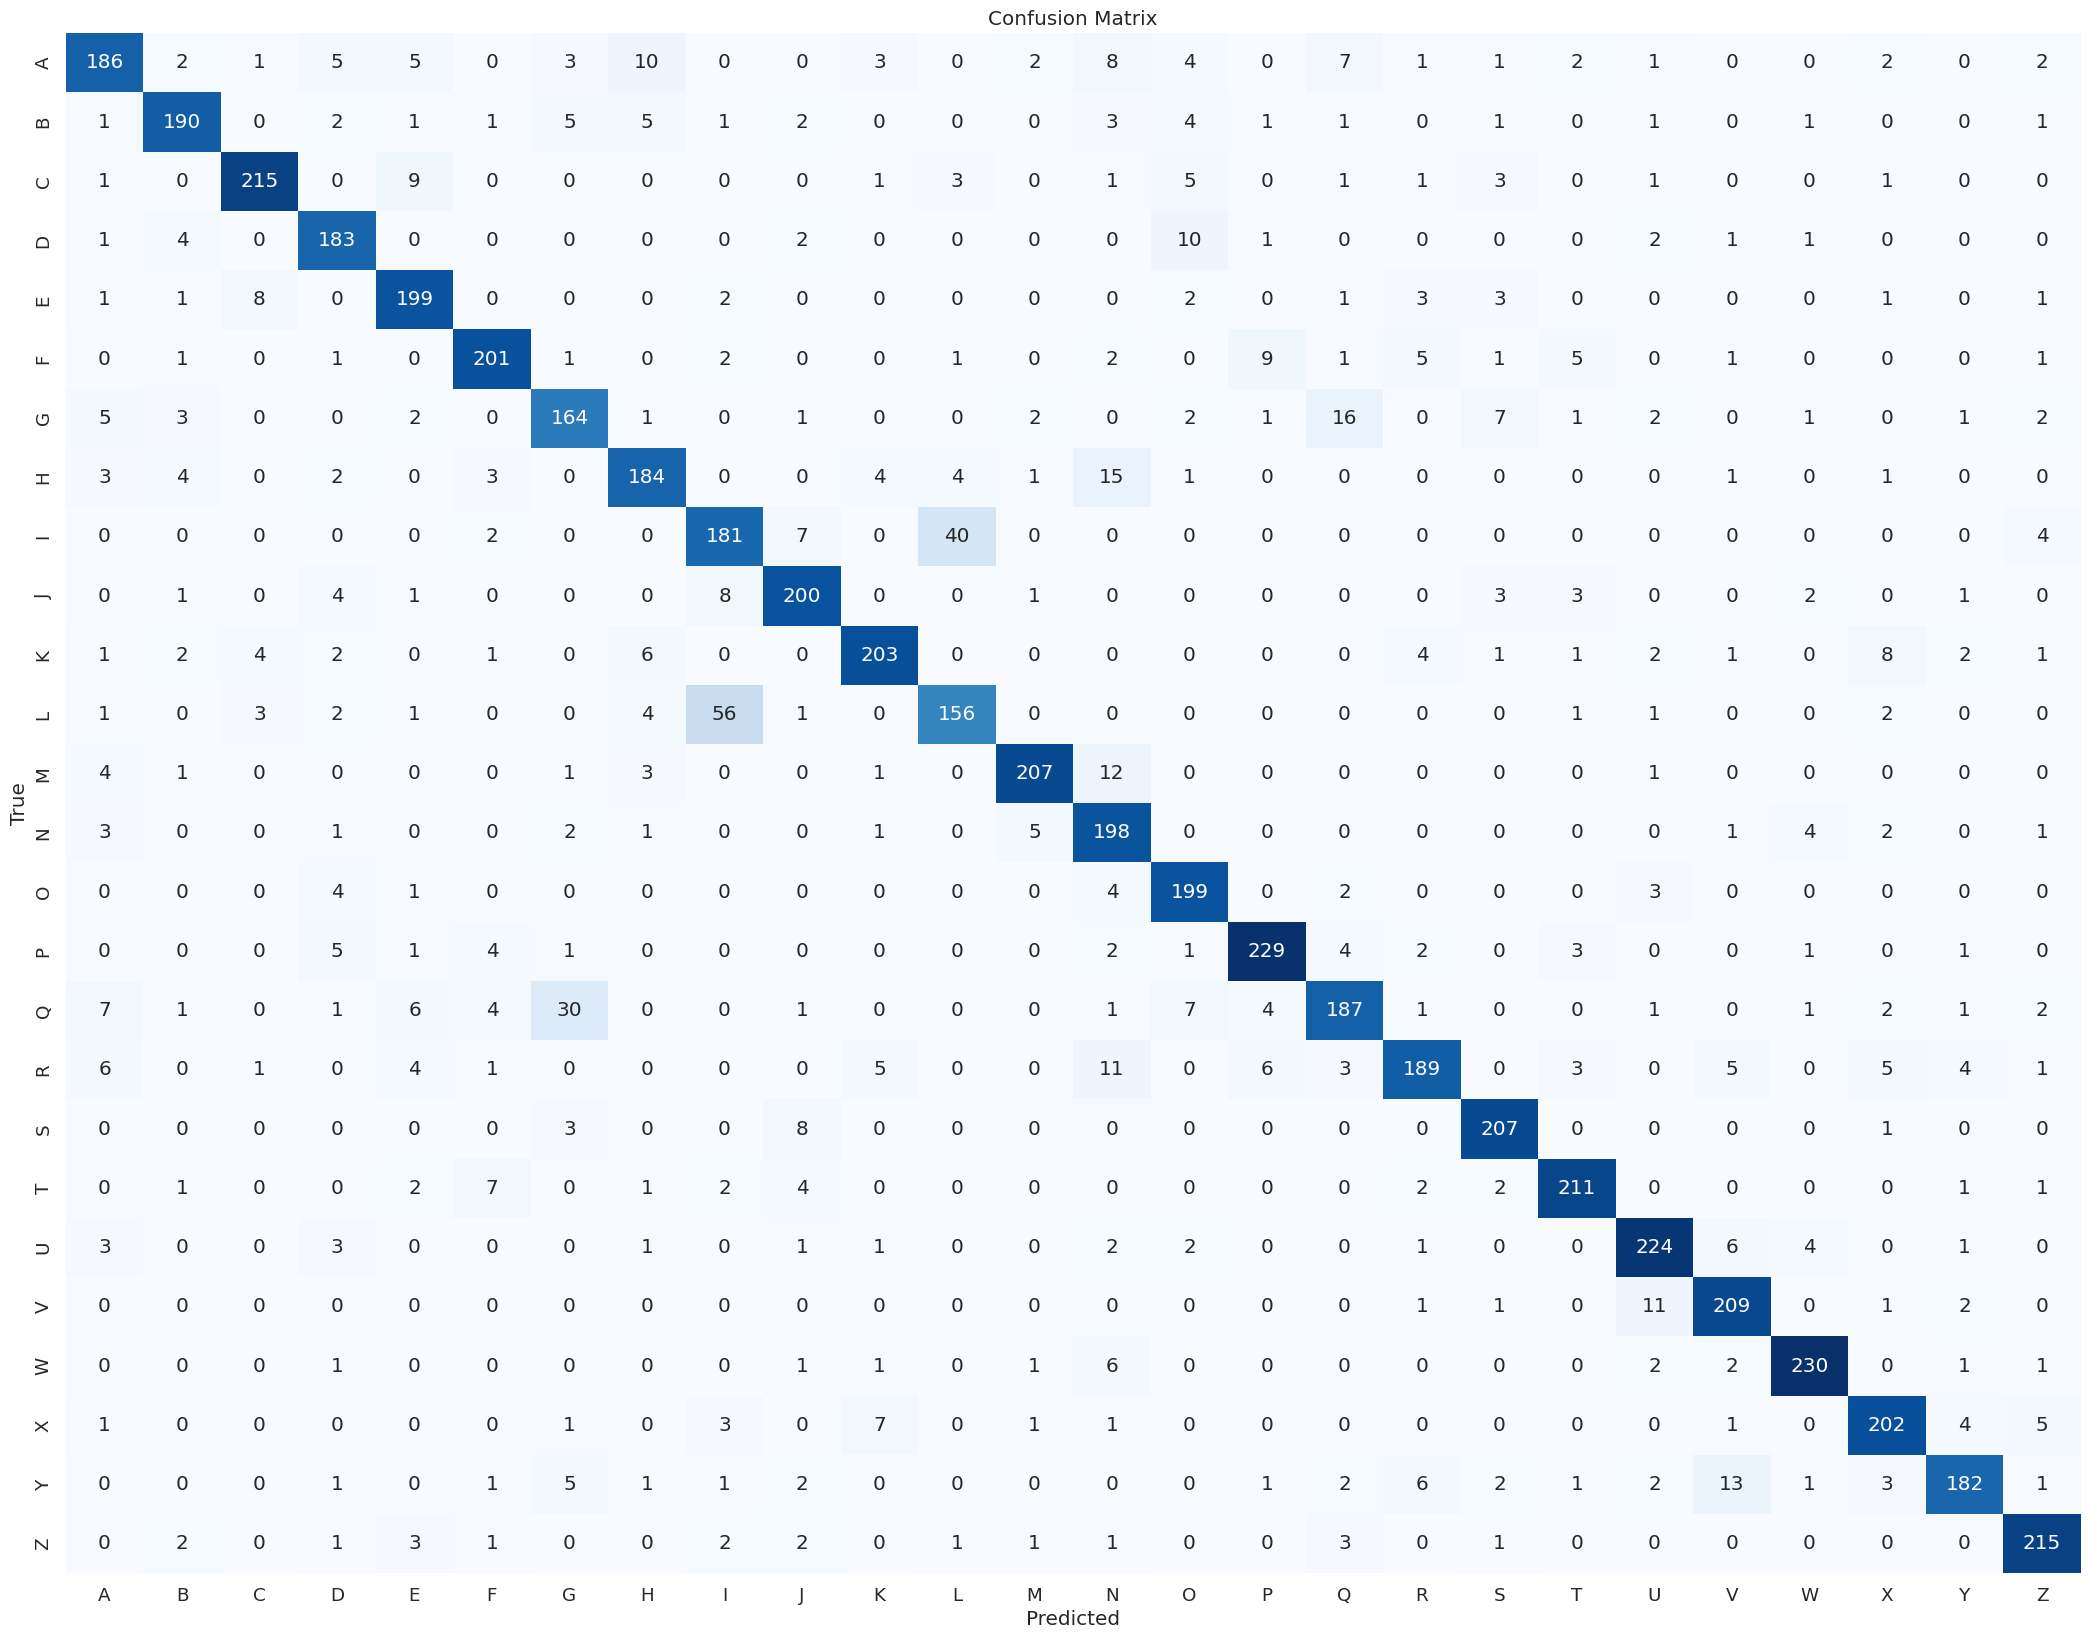

In [30]:
import joblib

# Load the trained parameters
parameters = joblib.load('rms_trained.joblib')

class_labels = ['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J',
              'K', 'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T',
              'U', 'V', 'W', 'X', 'Y', 'Z']

# Example usage:
# print(class_labels)

conf_matrix = compute_confusion_matrix(parameters, X_val, Y_val, class_labels)
conf_matrix_path = "confusion_matrix.png"
plot_confusion_matrix(conf_matrix, class_labels, title='Confusion Matrix', save_path=conf_matrix_path)


In [48]:
# print(predict1(X_val, parameters, activation="tanh"))
# print(X_val[0][0].shape)


[13 10 19 ...  7  2 18]


In [37]:
# Assuming Res_AL is a matrix where each column represents the predicted probabilities for each class
predicted_classes = np.argmax(Res_AL, axis=0)
print(predicted_classes)
# Assuming class_labels is a list of class names corresponding to the columns of Res_AL
class_labels = ['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J',
                  'K', 'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T',
                  'U', 'V', 'W', 'X', 'Y', 'Z']
# Map the predicted class indices to class labels
predicted_class_names = [class_labels[idx] for idx in predicted_classes]

# Display the predicted class names
print(predicted_class_names)


[13 10 19 ...  7  2 18]


IndexError: ignored

In [28]:
def sweeper(sweep_config,proj_name):
  sweep_id=wandb.sweep(sweep_config,project=proj_name)
  wandb.agent(sweep_id,train,project=proj_name)

In [ ]:
# Initialize wandb sweep configuration
sweep_config = {
    "name": "my_sweep",
    "method": "grid",
    "metric": {"name": "accuracy", "goal": "maximize"},
    "parameters": {
        "layer_dims": {"values": [[X_train.shape[0], 128, 128, 128, Y_train.shape[0]]]},
        "lr": {"values": [0.001]},
        "n_epoch": {"values": [1000]},
        "activation": {"values": ['relu','tanh']},
        "init_mode": {"values": ["xavier"]},
        "batch_size": {"values": [5400]},
        "lambd": {"values": [0.7]},
        "opt": {"values": ['sgd', 'momentum', 'rmsprop', 'adam']}
    }
}


In [ ]:
# proj_name = "Image_classification_emnist"
# sweep_id=wandb.sweep(sweep_config,project=proj_name)

NameError: ignored

In [ ]:
wandb.finish()

Cost,▁
Iteration,▁
Test_Accuracy,▁
Train_Accuracy,▁
Cost,4.17
Iteration,0
Test_Accuracy,9.0
Train_Accuracy,9.0


In [ ]:
import sys
import traceback
try:
  train()
  files.download('trained_parameters.joblib')

  wandb.finish()


except Exception as e:
  print(e)
  # exit gracefully, so wandb logs the problem
  print(traceback.print_exc(), file=sys.stderr)
  wandb.finish()
  exit(1)


[784, 128, 128, 128, 62]
Parameters:  [784, 128, 128, 128, 62] 0.001 xavier tanh 1000 0.7 adam

iter:0 	 cost: 4.23 	 train_acc:8.0 	 test_acc:8.0
iter:100 	 cost: 1.14 	 train_acc:67.0 	 test_acc:66.0
iter:200 	 cost: 0.86 	 train_acc:75.0 	 test_acc:74.0
iter:300 	 cost: 0.72 	 train_acc:78.0 	 test_acc:77.0
iter:400 	 cost: 0.65 	 train_acc:81.0 	 test_acc:80.0
iter:500 	 cost: 0.59 	 train_acc:82.0 	 test_acc:81.0
iter:600 	 cost: 0.55 	 train_acc:83.0 	 test_acc:82.0
iter:700 	 cost: 0.54 	 train_acc:83.0 	 test_acc:82.0
iter:800 	 cost: 0.47 	 train_acc:85.0 	 test_acc:84.0
iter:900 	 cost: 0.43 	 train_acc:86.0 	 test_acc:85.0

In [ ]:
sweep_config = {
    "name": "my_sweep",
    "method": "grid",
    "metric": {"name": "accuracy", "goal": "maximize"},
    "parameters": {
        "layer_dims": {"values": [[X_train.shape[0], 128, 128, 128, Y_train.shape[0]]]},
        "lr": {"values": [0.0001]},
        "n_epoch": {"values": [100]},
        "activation": {"values": ["tanh","relu"]},
        "init_mode": {"values": ["xavier"]},
        "lambd": {"values": [0.7]},
        "opt": {"values": ["adam","rmsprop","sgd","momentum"]}
    }
}

proj_name = "Image_classification_emnist"
sweep_id = wandb.sweep(sweep_config, project=proj_name)


##Predict from user input from ANVIL




In [80]:
import io

@anvil.server.callable
def predict1_colab(X_val, parameters, activation='tanh'):
    # Forward propagation
    A, _ = forward_prop(X_val, parameters, activation)

    # Convert probabilities to class labels
    predictions = np.argmax(A, axis=0)

    return predictions

@anvil.server.callable
def predict_colab(image):
    # Get the bytes of the image
    image_bytes = image.get_bytes()

    # Perform any necessary preprocessing on the image
    img = Image.open(io.BytesIO(image_bytes))
    img_array = np.array(img).reshape(28*28,-1)

    img_array = img_array.astype('float32') / 255.0
    print(img_array.shape)
    # Make predictions using the loaded model
    result = predict1(img_array, parameters, activation="tanh")

    # Assuming result is a string, modify accordingly based on your model output
    return str(result[0])


In [ ]:
import numpy as np
from emnist import extract_training_samples
import matplotlib.pyplot as plt
from PIL import Image

# Load EMNIST dataset
(X_train, y_train) = extract_training_samples('letters')

# Filter images containing only capital letters (A-Z)
capital_indices = np.where((y_train >= 10) & (y_train < 36))[0]

# Select 10 random indices from the filtered capital letters
random_indices = np.random.choice(capital_indices, 10, replace=False)

# Plot and save the images
for i, index in enumerate(random_indices):
    image_array = X_train[index].reshape((28, 28))
    label = chr(y_train[index] + 55)  # Convert label to corresponding capital letter (65 is ASCII for 'A')

    plt.imshow(image_array, cmap='gray')
    plt.title(f'EMNIST Capital Letter: {label}')
    plt.axis('off')

    # Save the image
    image_path = f'emnist_capital_image_{i + 11}.png'
    plt.savefig(image_path, bbox_inches='tight', pad_inches=0.0)
    plt.show()

    # Convert to PIL Image and save
    pil_image = Image.fromarray((image_array * 255).astype(np.uint8))
    pil_image.save(image_path)

    print(f'Image saved: {image_path}')

In [70]:
import shutil
import os

# Create a directory to store the images
output_directory = 'emnist_images'
os.makedirs(output_directory, exist_ok=True)

# Specify the image filenames
image_filenames = [f'emnist_capital_image_{i + 1}.png' for i in range(10, 20)]

# Assuming images are in the current working directory
# If images are in a different directory, provide the correct path
for filename in image_filenames:
    shutil.copy(filename, output_directory)

# Zip each image into a separate file
for filename in image_filenames:
    shutil.make_archive(os.path.join(output_directory, filename.split('.')[0]), 'zip', output_directory, filename)


In [71]:
from google.colab import files

# Specify the names of the zip files
zip_filenames = [f'emnist_capital_image_{i + 1}.png' for i in range(10,20)]
print(zip_filenames)
# Download each zip file
for zip_filename in zip_filenames:
    files.download(zip_filename)


['emnist_capital_image_11.png', 'emnist_capital_image_12.png', 'emnist_capital_image_13.png', 'emnist_capital_image_14.png', 'emnist_capital_image_15.png', 'emnist_capital_image_16.png', 'emnist_capital_image_17.png', 'emnist_capital_image_18.png', 'emnist_capital_image_19.png', 'emnist_capital_image_20.png']


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [66]:
import os
print(os.listdir())


['.config', 'emnist_capital_image_5.png', 'emnist_capital_image_3.zip', 'emnist_capital_image_7.png', 'emnist_capital_image_4.png', 'emnist_capital_image_10.png', 'emnist_capital_image_5.zip', 'emnist_images.zip', 'emnist_capital_image_11.png', 'emnist_capital_image_14.png', 'emnist_capital_image_2.png', 'emnist_capital_image_2.zip', 'emnist_capital_image_17.png', 'emnist_images', 'emnist_capital_image_8.zip', 'emnist_capital_image_13.png', 'emnist_capital_image_19.png', 'emnist_capital_image_12.png', 'emnist_capital_image_6.zip', 'emnist_capital_image_8.png', 'rms_trained.joblib', 'emnist_capital_image_3.png', 'emnist_capital_image_18.png', 'emnist_capital_image_15.png', 'emnist_capital_image_6.png', 'emnist_capital_image_20.png', 'emnist_capital_image_9.png', 'emnist_capital_image_7.zip', 'emnist_capital_image_1.png', 'emnist_capital_image_4.zip', 'emnist_capital_image_10.zip', 'confusion_matrix.png', 'emnist_capital_image_1.zip', 'emnist_capital_image_16.png', 'emnist_capital_image_